In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/Zhongyu/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Zhongyu/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## The CIFAR-10 Dataset
***
#### Dataset Overview
- The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
- The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 
- There are 10 classes in the dataset. The classes are completely mutually exclusive. 
 - airplane										
 - automobile										
 - bird										
 - cat										
 - deer										
 - dog										
 - frog										
 - horse										
 - ship										
 - truck
 
#### Datafile Overview
- data_batch_num & test_batch
    - data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
    - labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.
- batches.meta
    - label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.
***
#### Load Data

In [2]:
def unpickle(file):
    # load pickled data
    fo = open(file, 'rb')
    dict = pickle.load(fo)
    fo.close()
    return dict

In [3]:
train_fnroot = "cifar-10-batches-py/data_batch_"
test_filename = "cifar-10-batches-py/test_batch"
meta_filename = "cifar-10-batches-py/batches.meta"

In [4]:
# Load Training Dataset
train_dateset = None
train_labels = None
for i in range(1,6):
    train_filename = train_fnroot + str(i)
    batch = unpickle(train_filename)
    if i==1:
        train_dataset = batch['data']
        train_labels = np.array(batch['labels'])
    else:
        train_dataset = np.concatenate((train_dataset, batch['data']), axis=0)
        train_labels = np.concatenate((train_labels, batch['labels']))
del batch # free space

In [5]:
# Split 20% of training batches as validation dataset
train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(train_dataset, train_labels, 
                                                                              test_size=10000, random_state=897,
                                                                              stratify=train_labels)

In [6]:
# Load Test Dataset
test_batch = unpickle(test_filename)
test_dataset = test_batch['data']
test_labels = np.array(test_batch['labels'])
del test_batch
# Load Label Names
label_names = unpickle(meta_filename)['label_names']

In [56]:
# Print training data, testing data sizes
print 'Dataset\t\tFeatureShape\tLabelShape'
print 'Training set:\t', train_dataset.shape,'\t', train_labels.shape
print 'Validation set:\t', valid_dataset.shape,'\t', valid_labels.shape
print 'Testing set:\t', test_dataset.shape, '\t', test_labels.shape

Dataset		FeatureShape	LabelShape
Training set:	(40000, 3072) 	(40000,)
Validation set:	(10000, 3072) 	(10000,)
Testing set:	(10000, 3072) 	(10000,)


In [63]:
# Categorize labels into two coarse categories: Animals and Transportation Vehicles
print "Animals:\t\t\t", label_names[2:8]
print "Transportation Vehicles:\t", label_names[:2], label_names[8:]

Animals:			['bird', 'cat', 'deer', 'dog', 'frog', 'horse']
Transportation Vehicles:	['airplane', 'automobile'] ['ship', 'truck']


In [64]:
# Create category labels
train_category = np.logical_and(train_labels>=2, train_labels<8).astype('int64')
valid_category = np.logical_and(valid_labels>=2, valid_labels<8).astype('int64')
test_category = np.logical_and(test_labels>=2, test_labels<8).astype('int64')

***
### Reshape the data into 32x32x3 format

In [7]:
# Reshape the data into pixel by pixel by RGB channels
train_reshape = np.rollaxis(train_dataset.reshape((-1,3,32,32)), 1, 4)
valid_reshape = np.rollaxis(valid_dataset.reshape((-1,3,32,32)), 1, 4)
test_reshape = np.rollaxis(test_dataset.reshape((-1,3,32,32)), 1, 4)

In [8]:
print 'Dataset\t\tFeatureShape\t\tLabelShape'
print 'Training set:\t', train_reshape.shape,'\t', train_labels.shape
print 'Validation set:\t', valid_reshape.shape, '\t', valid_labels.shape
print 'Testing set:\t', test_reshape.shape, '\t', test_labels.shape

Dataset		FeatureShape		LabelShape
Training set:	(40000, 32, 32, 3) 	(40000,)
Validation set:	(10000, 32, 32, 3) 	(10000,)
Testing set:	(10000, 32, 32, 3) 	(10000,)


frog


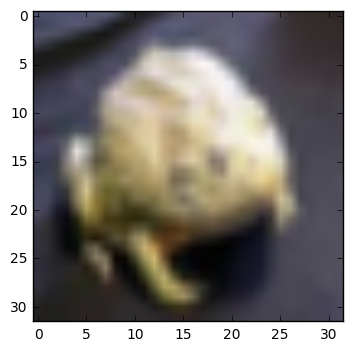

In [59]:
# Visualize samples
print label_names[train_labels[3377]]
sample = train_reshape[3377, :, :, :]
plt.imshow(sample);plt.show()

***
#### Data Augmentation
- Left-Right Flipping
- PCA jittering

In [8]:
# Mirror Reflection/Left-Right Flip the Input Data
train_LRF = train_reshape[:,:,::-1,:]
train_LRF.shape

(40000, 32, 32, 3)

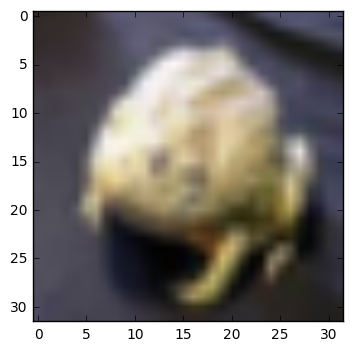

In [41]:
# Verify and visualize the mirror reflection/Left-Right Flip
sample_LRF = train_LRF[3377,:,:,:]
plt.imshow(sample_LRF);plt.show()

In [56]:
# PCA RGB color channel jitter
import matplotlib.mlab as matlab
def pca_jitter(image, std):
    img2d = image.reshape((-1,3))
    pca_data = matlab.PCA(img2d)
    np.random.seed(5319)
    rand_noise = np.random.normal(0.0, std, (1,1024))
    eigen_val = pca_data.fracs[:,None]
    factors = np.dot(eigen_val, rand_noise)
    eigen_vec = pca_data.Wt
    jitter = np.transpose(np.dot(eigen_vec, factors)).reshape((32,32,3))
    return jitter

==================== Original Image ====================


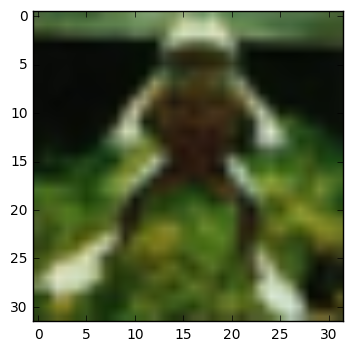

==================== PCA jittered Image ====================


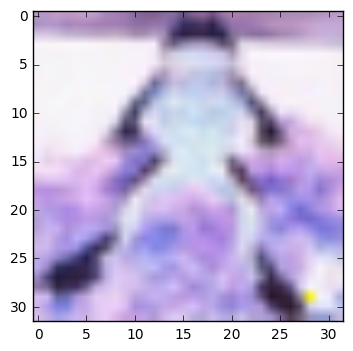

In [57]:
# Visualize PCA jitter effect on one sample
img = train_reshape[1,:,:,:]
jitter = pca_jitter(img, .01)
img_jitter = img + jitter
print '='*20, "Original Image",'='*20
plt.imshow(img);plt.show()
print '='*20,"PCA jittered Image", '='*20
plt.imshow(img_jitter);plt.show()

In [179]:
# Too Slow
#train_jitter = np.copy(train_reshape)
#for i in range(train_reshape.shape[0]):
    #train_jitter[i,:,:,:] = train_jitter[i,:,:,:] + pca_jitter(train_jitter, .01)

### Prepare data for training
- Concatenate augmented data with training data - Training size: 80000
- Reformat test data - One Hot Encode
- Define accuracy function - Accuarcy (since false positive and false negative don't have much of meaning in this image classificaton setting)

In [9]:
# Prepare Data
image_size = 32
num_labels = 10
num_channels = 3
num_categories = 2

# Data Augmentation Choice
#train_dataset = np.concatenate((train_reshape, train_LRF), 0).astype(np.float32)
#train_labels = np.concatenate((train_labels, train_labels))
#train_labels = (np.arange(num_labels)==train_labels[:,None]).astype(np.float32)
#del train_LRF

# Non-Data Augmentation Choice - start with this to explore
train_dataset = train_reshape.astype(np.float32)
train_labels = (np.arange(num_labels)==train_labels[:,None]).astype(np.float32)
#del train_reshape


valid_dataset = valid_reshape.astype(np.float32)
valid_labels = (np.arange(num_labels)==valid_labels[:, None]).astype(np.float32)
#del valid_reshape

test_dataset = test_reshape.astype(np.float32)
test_labels = (np.arange(num_labels)==test_labels[:,None]).astype(np.float32)
#del test_reshape

print 'Dataset\t\tFeatureShape\t\tLabelShape'
print 'Training set:\t', train_dataset.shape,'\t', train_labels.shape
print 'Validation set:\t', valid_dataset.shape, '\t', valid_labels.shape
print 'Testing set:\t', test_dataset.shape, '\t', test_labels.shape

Dataset		FeatureShape		LabelShape
Training set:	(40000, 32, 32, 3) 	(40000, 10)
Validation set:	(10000, 32, 32, 3) 	(10000, 10)
Testing set:	(10000, 32, 32, 3) 	(10000, 10)


In [10]:
# Define accuracy func
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

***
### Convolution Neural Network

In [47]:
# Shared parameters
batch_size = 16
kernel1 = 3
kernel2 = 5
num_filter = 64
fc_size1 = 512
#fc_size2 = 512
# fc_size2 = 64

In [48]:
# The Simple Linearly Cascade Network
graph = tf.Graph()

with graph.as_default():
    # Input Data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Setup Variables
    conv1_wt = tf.Variable(tf.truncated_normal([kernel2, kernel2, num_channels, num_filter], stddev=.1))
    conv1_bi = tf.Variable(tf.zeros(shape=[num_filter]))
    
    conv2_wt = tf.Variable(tf.truncated_normal([kernel1, kernel1, num_filter, num_filter], stddev=.1))
    conv2_bi = tf.Variable(tf.constant(1.0, shape=[num_filter]))
    
    fc1_wt = tf.Variable(tf.truncated_normal([((image_size/2-kernel1+1)/2)**2*num_filter, fc_size1], stddev=.1))
    fc1_bi = tf.Variable(tf.constant(1.0, shape=[fc_size1]))
    
    #fc2_wt = tf.Variable(tf.truncated_normal([fc_size1, fc_size2], stddev=.1))
    #fc2_bi = tf.Variable(tf.zeros([fc_size2]))
    
    fc3_wt = tf.Variable(tf.truncated_normal([fc_size1, num_labels], stddev=.1))
    fc3_bi = tf.Variable(tf.zeros([num_labels]))
    
    # Parameters
    keep_prob = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(.00001, global_step, 1000, .7, staircase=True)
    
    # Model
    def model(data, train=True, keep_prob=.7):
        conv = tf.nn.conv2d(data, conv1_wt, [1,1,1,1], padding='SAME')
        relu = tf.nn.relu(conv + conv1_bi)
        pool = tf.nn.max_pool(relu, [1,2,2,1], [1,2,2,1], padding='SAME')
        
        conv = tf.nn.conv2d(pool, conv2_wt, [1,1,1,1], padding='VALID')
        relu = tf.nn.relu(conv + conv2_bi)
        pool = tf.nn.max_pool(relu, [1,2,2,1], [1,2,2,1], padding='SAME')
        
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
        fc = tf.nn.relu(tf.matmul(reshape, fc1_wt) + fc1_bi)
        #if train:
            #fc = tf.nn.dropout(fc, keep_prob)
        #fc = tf.nn.relu(tf.matmul(fc, fc2_wt) + fc2_bi)
        if train:
            fc = tf.nn.dropout(fc, keep_prob)
        return tf.matmul(fc, fc3_wt) + fc3_bi
    
    # Compute Loss Function
    logits = model(tf_train_dataset, True, keep_prob)
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, tf_train_labels))
    loss = tf.reduce_mean(tf.abs(logits - tf_train_labels))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(.0001).minimize(loss)
    
    # Prediction
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, False))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, False))

In [49]:
num_steps = 301
loss_val_cd = np.zeros(num_steps)
train_acc_cd = np.zeros(num_steps)
valid_acc_cd = np.zeros(num_steps)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : .7}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        loss_val_cd[step] = l
        train_acc_cd[step] = accuracy(predictions, batch_labels)
        valid_acc_cd[step] = accuracy(valid_prediction.eval(), valid_labels)
        if ((step % 50 == 0)):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % train_acc_cd[step])
            print('Validation accuracy: %.1f%%' % valid_acc_cd[step])
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1326.695557
Minibatch accuracy: 12.5%
Validation accuracy: 7.7%
Minibatch loss at step 50: 5.889974
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 100: 6.609506
Minibatch accuracy: 25.0%
Validation accuracy: 10.1%
Minibatch loss at step 150: 1.920467
Minibatch accuracy: 18.8%
Validation accuracy: 10.2%
Minibatch loss at step 200: 2.028562
Minibatch accuracy: 6.2%
Validation accuracy: 10.2%
Minibatch loss at step 250: 1.352534
Minibatch accuracy: 6.2%
Validation accuracy: 10.1%
Minibatch loss at step 300: 1.402795
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Test accuracy: 9.9%


### Parameters
batch_size = 16
kernel1 = 3
kernel2 = 5
num_filter = 64
fc_size1 = 1024
fc_size2 = 512

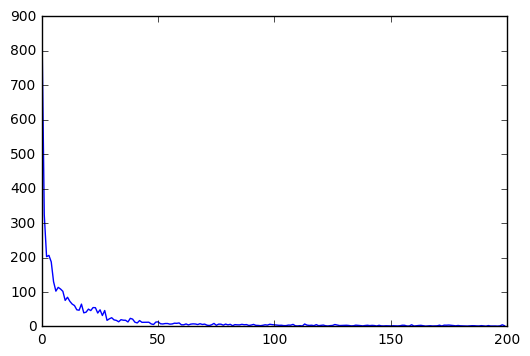

In [44]:
plt.plot(range(200), loss_val_cd[:-1]);plt.show()

[]

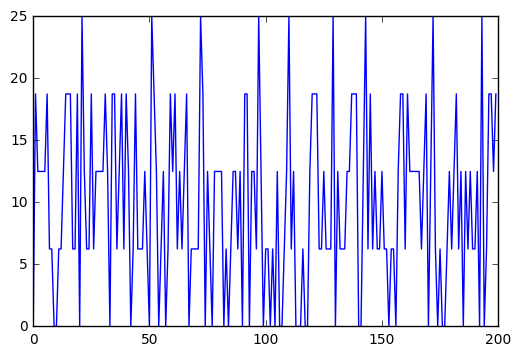

In [45]:
plt.plot(range(200), train_acc_cd[:-1]);plt.plot()

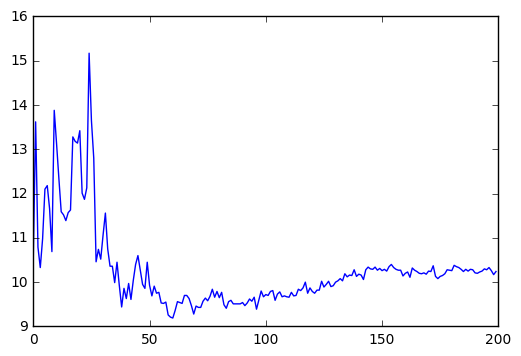

In [46]:
plt.plot(range(200), valid_acc_cd[:-1]);plt.show()

### Parameters
batch_size = 16
kernel1 = 3
kernel2 = 5
num_filter = 64
fc_size1 = 1024

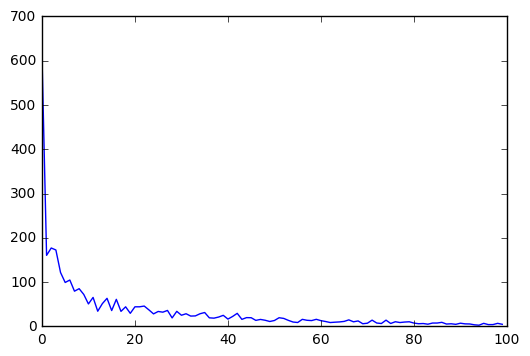

In [38]:
plt.plot(range(100), loss_val_cd[:-1]);plt.show()

[]

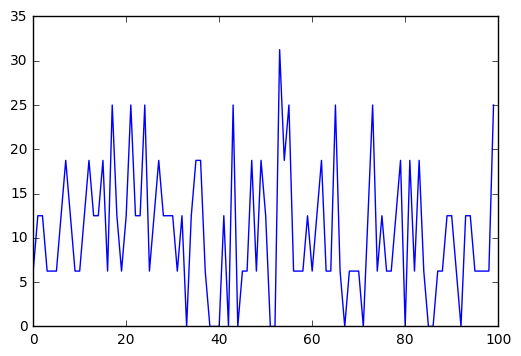

In [39]:
plt.plot(range(100), train_acc_cd[:-1]);plt.plot()

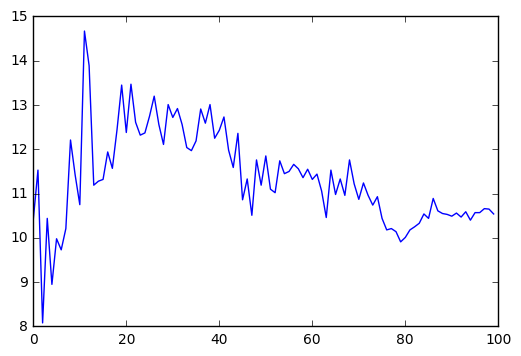

In [40]:
plt.plot(range(100), valid_acc_cd[:-1]);plt.show()

### Parameters
batch_size = 16
kernel1 = 3
kernel2 = 5
num_filter = 64
fc_size1 = 512

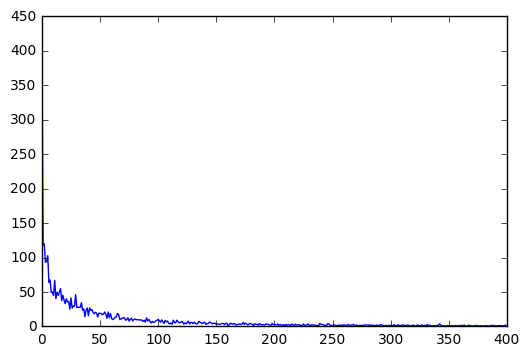

In [27]:
plt.plot(range(400), loss_val_cd[:400]);plt.show()

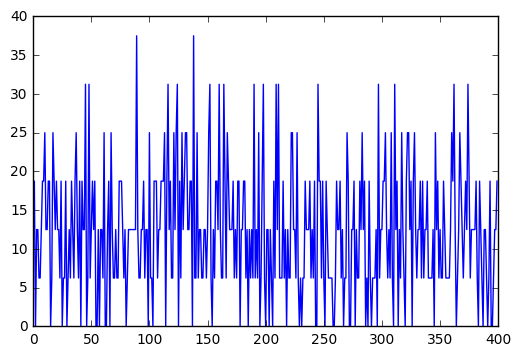

In [31]:
plt.plot(range(400), train_acc_cd[:400]);plt.show()

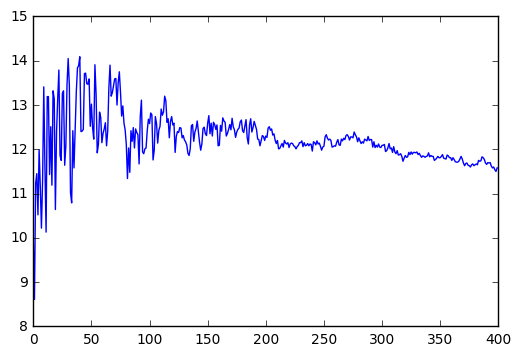

In [32]:
plt.plot(range(400), valid_acc_cd[:400]);plt.show()

### Parameters
batch_size = 16
kernel1 = 3
kernel2 = 5
num_filter = 64
fc_size1 = 128

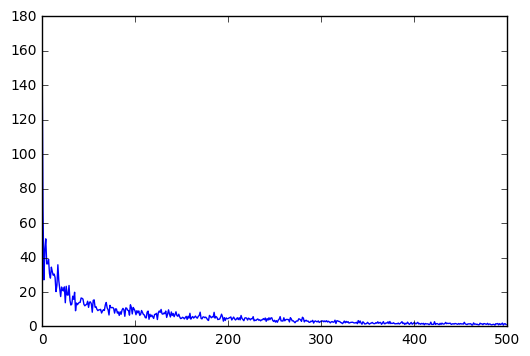

In [77]:
plt.plot(range(500), loss_val_cd[:-1]);plt.show()

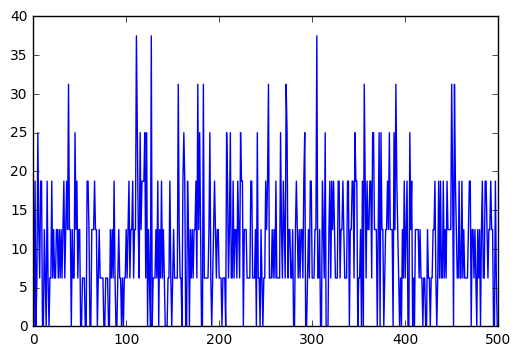

In [79]:
plt.plot(range(500), train_acc_cd[:-1]);plt.show()

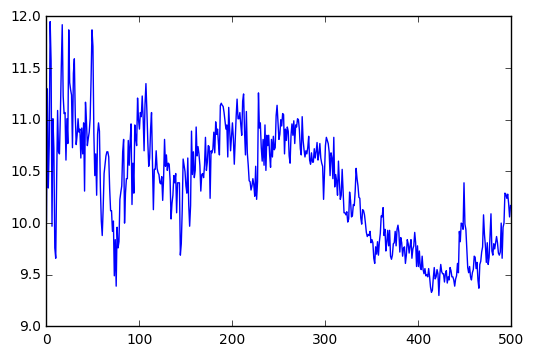

In [80]:
plt.plot(range(500), valid_acc_cd[:-1]);plt.show()

***
### Build Convolution Neural Network - Inception vs. Linearly Cascade Network
- A simple Inception Network

In [25]:
# Shared parameters
batch_size = 16
kernel1 = 3
kernel2 = 5
num_filter = 128
fc_size1 = 128
# fc_size2 = 64

In [114]:
# The Inception Network
graph = tf.Graph()

with graph.as_default():
    # Input Data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Setup Variables
    conv1_wt = tf.Variable(tf.truncated_normal([kernel2, kernel2, num_channels, num_filter], stddev=.1))
    conv1_bi = tf.Variable(tf.zeros(shape=[num_filter]))
    
    incep1_wt = tf.Variable(tf.truncated_normal([kernel1, kernel1, num_filter, num_filter], stddev=.1))
    incep1_bi = tf.Variable(tf.constant(1.0, shape=[num_filter]))
    
    incep2_wt = tf.Variable(tf.truncated_normal([kernel2, kernel2, num_filter, num_filter], stddev=.1))
    incep2_bi = tf.Variable(tf.constant(1.0, shape=[num_filter]))
    
    fc1_wt = tf.Variable(tf.truncated_normal([image_size/4*image_size/4*num_filter*2, fc_size1], stddev=.1))
    fc1_bi = tf.Variable(tf.constant(1.0, shape=[fc_size1]))
    
    fc2_wt = tf.Variable(tf.truncated_normal([fc_size1, num_labels], stddev=.1))
    fc2_bi = tf.Variable(tf.zeros([num_labels]))
    
    # Parameters
    keep_prob = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(.0001, global_step, 1000, .7, staircase=True)
    
    # Model
    def model(data, train=True, keep_prob=.7):
        conv = tf.nn.conv2d(data, conv1_wt, [1,1,1,1], padding='SAME')
        relu = tf.nn.relu(conv + conv1_bi)
        pool = tf.nn.max_pool(relu, [1,2,2,1], [1,2,2,1], padding='SAME')
        
        incep1 = tf.nn.conv2d(pool, incep1_wt, [1,1,1,1], padding='SAME')
        relu1 = tf.nn.relu(incep1 + incep1_bi)
        incep2 = tf.nn.conv2d(pool, incep2_wt, [1,1,1,1], padding='SAME')
        relu2 = tf.nn.relu(incep2 + incep2_bi)
        
        concat = tf.concat(3, [relu1, relu2])
        
        pool = tf.nn.max_pool(concat, [1,2,2,1], [1,2,2,1], padding='SAME')
        
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
        fc = tf.nn.relu(tf.matmul(reshape, fc1_wt) + fc1_bi)
        if train:
            fc = tf.nn.dropout(fc, keep_prob)
        return tf.matmul(fc, fc2_wt) + fc2_bi
    
    # Compute Loss Function
    logits = model(tf_train_dataset, True, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(.0001).minimize(loss)
    
    # Prediction
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, False))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, False))

In [115]:
num_steps = 501
loss_val_ic = np.zeros(num_steps)
train_acc_ic = np.zeros(num_steps)
valid_acc_ic = np.zeros(num_steps)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : .7}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        loss_val_ic[step] = l
        train_acc_ic[step] = accuracy(predictions, batch_labels)
        valid_acc_ic[step] = accuracy(valid_prediction.eval(), valid_labels)
        if (step % 1 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % train_acc_ic[step])
            print('Validation accuracy: %.1f%%' % valid_acc_ic[step])
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2720.898193
Minibatch accuracy: 3.1%
Validation accuracy: 10.0%
Minibatch loss at step 1: 7034.567383
Minibatch accuracy: 12.5%
Validation accuracy: 12.1%
Minibatch loss at step 2: 2647.082031
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 3: 2663.882324
Minibatch accuracy: 3.1%
Validation accuracy: 9.3%
Minibatch loss at step 4: 274.416382
Minibatch accuracy: 9.4%
Validation accuracy: 10.2%
Minibatch loss at step 5: 110.636795
Minibatch accuracy: 9.4%
Validation accuracy: 10.8%
Minibatch loss at step 6: 69.627930
Minibatch accuracy: 18.8%
Validation accuracy: 10.0%
Minibatch loss at step 7: 61.893349
Minibatch accuracy: 12.5%
Validation accuracy: 9.2%
Minibatch loss at step 8: 43.656090
Minibatch accuracy: 6.2%
Validation accuracy: 8.7%
Minibatch loss at step 9: 50.713898
Minibatch accuracy: 12.5%
Validation accuracy: 9.5%
Minibatch loss at step 10: 44.571690
Minibatch accuracy: 3.1%
Validation accuracy: 9.5%
Minibatch 

KeyboardInterrupt: 

***
- A simple Linearly Cascade Network

In [26]:
# The Simple Linearly Cascade Network
graph = tf.Graph()

with graph.as_default():
    # Input Data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Setup Variables
    conv1_wt = tf.Variable(tf.truncated_normal([kernel2, kernel2, num_channels, num_filter], stddev=.1))
    conv1_bi = tf.Variable(tf.zeros(shape=[num_filter]))
    
    conv2_wt = tf.Variable(tf.truncated_normal([kernel1, kernel1, num_filter, num_filter], stddev=.1))
    conv2_bi = tf.Variable(tf.constant(1.0, shape=[num_filter]))
    
    conv3_wt = tf.Variable(tf.truncated_normal([kernel2, kernel2, num_filter, num_filter], stddev=.1))
    conv3_bi = tf.Variable(tf.constant(1.0, shape=[num_filter]))
    
    fc1_wt = tf.Variable(tf.truncated_normal([image_size/4*image_size/4*num_filter, fc_size1], stddev=.1))
    fc1_bi = tf.Variable(tf.constant(1.0, shape=[fc_size1]))
    
    fc2_wt = tf.Variable(tf.truncated_normal([fc_size1, num_labels], stddev=.1))
    fc2_bi = tf.Variable(tf.zeros([num_labels]))
    
    # Parameters
    keep_prob = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(.00001, global_step, 1000, .7, staircase=True)
    
    # Model
    def model(data, train=True, keep_prob=.7):
        conv = tf.nn.conv2d(data, conv1_wt, [1,1,1,1], padding='SAME')
        relu = tf.nn.relu(conv + conv1_bi)
        pool = tf.nn.max_pool(relu, [1,2,2,1], [1,2,2,1], padding='SAME')
        
        conv = tf.nn.conv2d(pool, conv2_wt, [1,1,1,1], padding='SAME')
        relu = tf.nn.relu(conv + conv2_bi)
        
        conv = tf.nn.conv2d(relu, conv3_wt, [1,1,1,1], padding='SAME')
        relu = tf.nn.relu(conv + conv3_bi)
        
        pool = tf.nn.max_pool(relu, [1,2,2,1], [1,2,2,1], padding='SAME')
        
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
        fc = tf.nn.relu(tf.matmul(reshape, fc1_wt) + fc1_bi)
        if train:
            fc = tf.nn.dropout(fc, keep_prob)
        return tf.matmul(fc, fc2_wt) + fc2_bi
    
    # Compute Loss Function
    logits = model(tf_train_dataset, True, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(.00001).minimize(loss)
    
    # Prediction
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, False))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, False))

In [ ]:
num_steps = 10001
loss_val_cd = np.zeros(num_steps)
train_acc_cd = np.zeros(num_steps)
valid_acc_cd = np.zeros(num_steps)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : .7}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        loss_val_cd[step] = l
        train_acc_cd[step] = accuracy(predictions, batch_labels)
        valid_acc_cd[step] = accuracy(valid_prediction.eval(), valid_labels)
        if (step % 5 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % train_acc_cd[step])
            print('Validation accuracy: %.1f%%' % valid_acc_cd[step])
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))